<h1 style="text-align: center">
Deep Learning HW4 </br>
VAE and CVAE
</h1>


### Full Name: Yasin Sharifbeigy
### Student ID: 97101864

# Import necessary libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision

# Define the MNIST dataset and data loader

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 131603273.15it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 39755724.92it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 34684725.12it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 4931537.35it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Data Visualization

In [ ]:
# Function to display an image
def show_image(image, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

# Function to show random images from each class
def show_random_images_from_each_class(dataset, num_images_per_class=4, figsize=(10, 20)):
    class_labels = list(range(10))
    fig, axs = plt.subplots(len(class_labels), num_images_per_class, figsize=figsize)

    for i, label in enumerate(class_labels):
        class_indices = [idx for idx, target in enumerate(dataset.targets) if target == label]
        random_indices = random.sample(class_indices, num_images_per_class)

        for j, idx in enumerate(random_indices):
            image, target = dataset[idx]
            axs[i, j].imshow(image[0], cmap='gray')
            axs[i, j].set_title(f"Class {label}", fontsize=16)
            axs[i, j].axis('off')
            axs[i, j].set_aspect('equal')
            axs[i, j].grid(True)

    plt.tight_layout()
    plt.show()

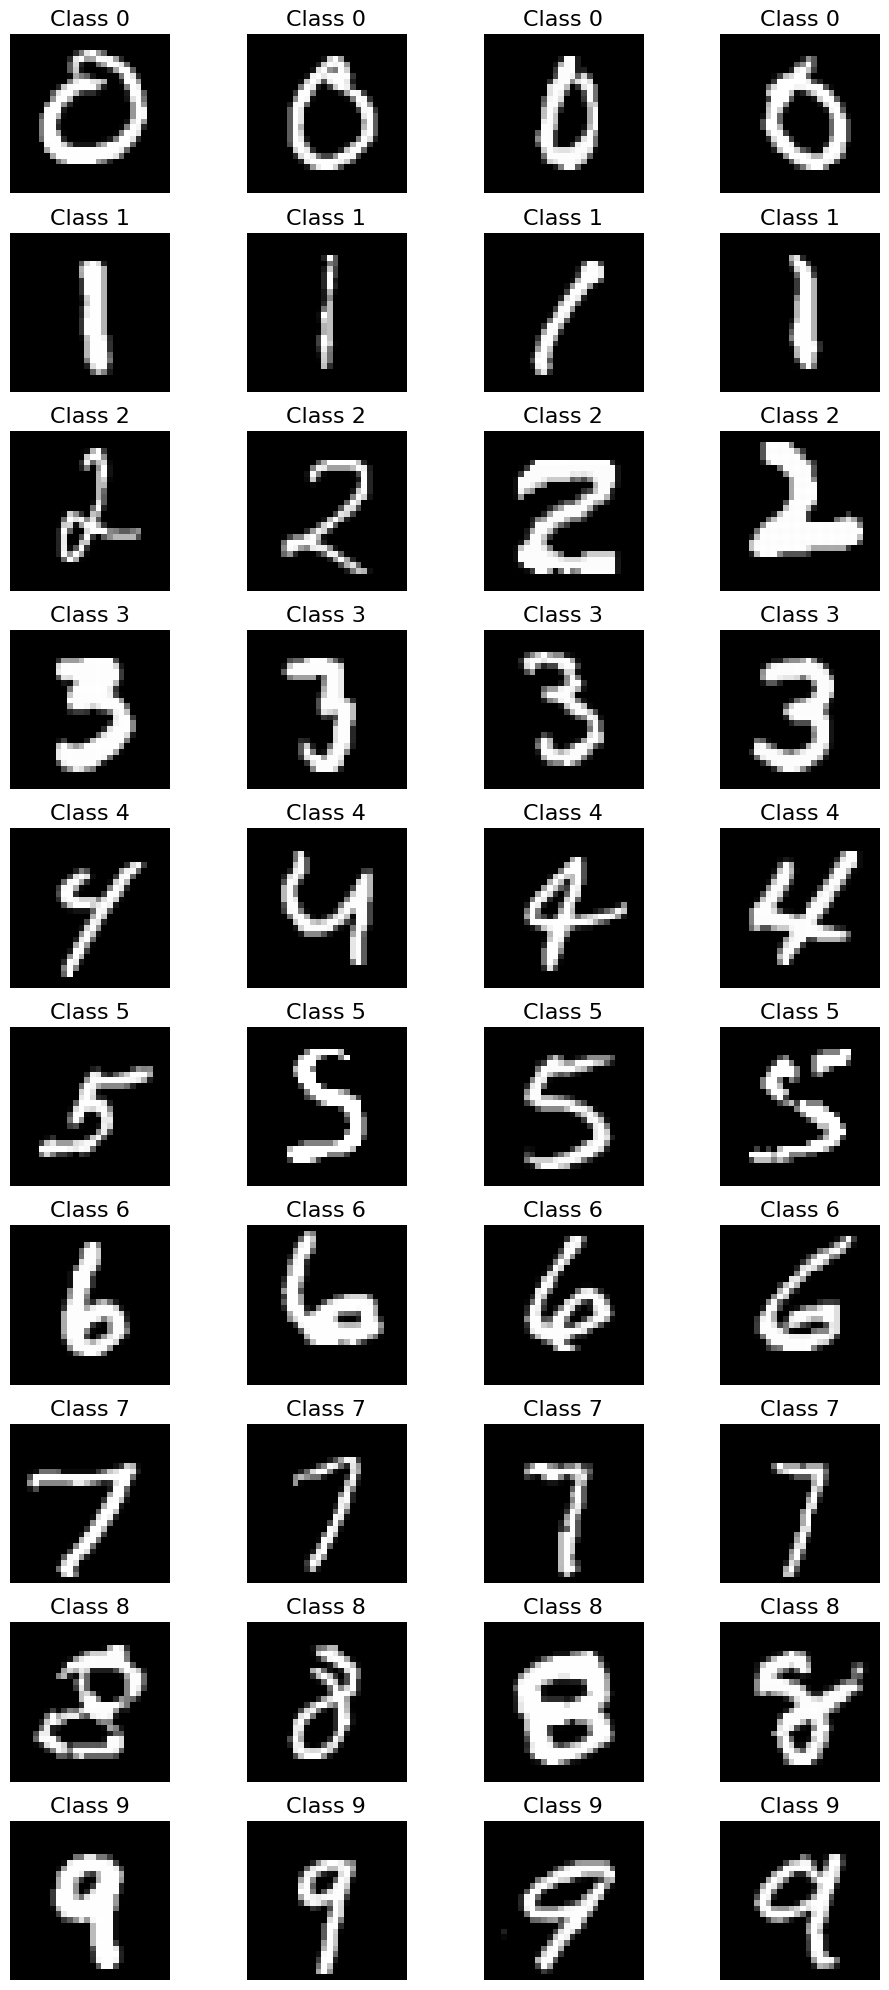

In [ ]:
# Use the function to show random images from each class
show_random_images_from_each_class(train_dataset, num_images_per_class=4)

Exercise: Variational Autoencoders (VAE) and Conditional Variational Autoencoders (CVAE)

with MLP Architectures

In this exercise, we'll explore Variational Autoencoders (VAE) and Conditional VAE (CVAE) using PyTorch.

We will implement these models using Multi-Layer Perceptrons (MLP)

Let's get started!

# 1) VAE --> MLP

In [ ]:
# Define a simple VAE class with MLP architecture

class VAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE_MLP, self).__init__()
        # TODO: Define the architecture of the encoder and decoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid(),
        )

    def reparameterize(self, mu, logvar):
        z = torch.randn(mu.shape, device = mu.device)
        return mu + torch.exp(logvar/2) * z

    def forward(self, x):
        out_encoder = self.encoder(x)
        mu = self.fc_mu(out_encoder)
        logvar = self.fc_logvar(out_encoder)
        latent_samples = self.reparameterize(mu, logvar)
        out = self.decoder(latent_samples)
        return out, (mu, logvar)

In [ ]:
# Define VAE loss function

def vae_loss(recon, data, mu, logvar):
    # TODO: Implement the reconstruction loss
    reconstruction_loss = F.binary_cross_entropy(recon, data, reduction='sum')

    # TODO: Implement the KL divergence loss
    kl_divergence = 0.5 * (torch.exp(logvar) + mu**2 - 1 - logvar).sum()

    # TODO: Return the total loss as the sum of reconstruction and KL divergence losses
    return reconstruction_loss + kl_divergence

In [ ]:
# Training Loop - VAE (MLP)
def train_vae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    if(torch.cuda.is_available()):
      device = 'cuda'
    else:
      device = 'cpu'
    model.to(device)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            # TODO: Forward process
            N = len(data)
            # TODO: Flatten the data and recon tensors
            data = data.view(N, -1).to(device)
            recon, (mu, logvar) = model(data)

            # TODO: Calculate the loss using the vae_loss function
            loss = vae_loss(recon, data, mu, logvar)

            # TODO: Backpropagation and optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss = total_loss + loss.item()

        avg_loss = total_loss/len(train_loader)

        print(f'VAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_samples = 6  # Generate num_samples random samples
                sample = torch.randn(num_samples, 2)
                sample = model.decoder(sample.to(device)).view(num_samples, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_samples, figsize=(15, 2))
                for i in range(num_samples):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].axis('off')
                plt.show()

        # TODO: Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()  # TODO: Save the model

    # TODO: Save the best model to a file
    torch.save(best_model, 'best_vae_mlp_model.pth')
    print("Best model saved as 'best_vae_mlp_model.pth'")



##################################################
VAE-MLP Epoch [1/20], Loss: 11566.064635840052
Sample Images:


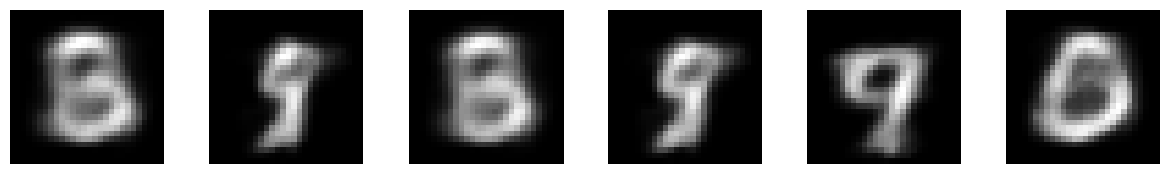


##################################################
VAE-MLP Epoch [2/20], Loss: 10445.229596819196
Sample Images:


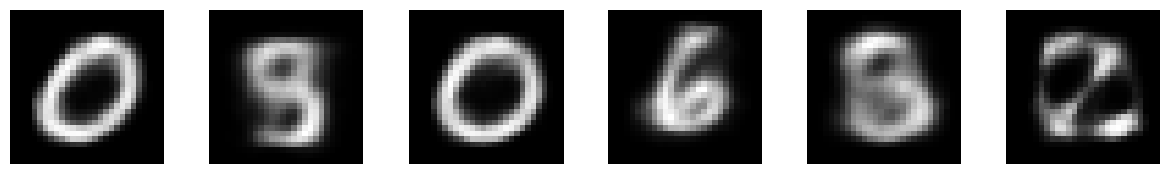


##################################################
VAE-MLP Epoch [3/20], Loss: 10185.356059580723
Sample Images:


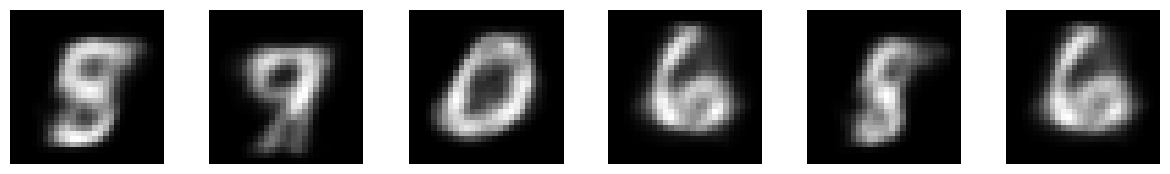


##################################################
VAE-MLP Epoch [4/20], Loss: 10037.773050206557
Sample Images:


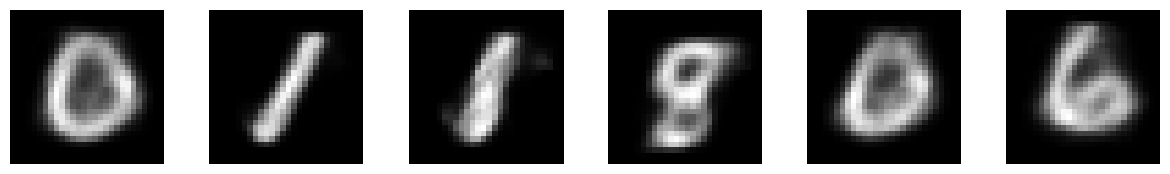


##################################################
VAE-MLP Epoch [5/20], Loss: 9934.307496939133
Sample Images:


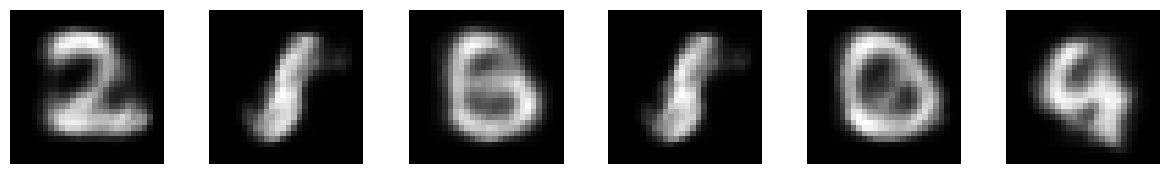


##################################################
VAE-MLP Epoch [6/20], Loss: 9845.456888097182
Sample Images:


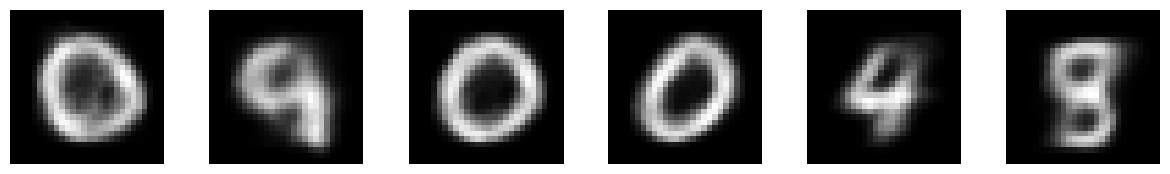


##################################################
VAE-MLP Epoch [7/20], Loss: 9765.847783786148
Sample Images:


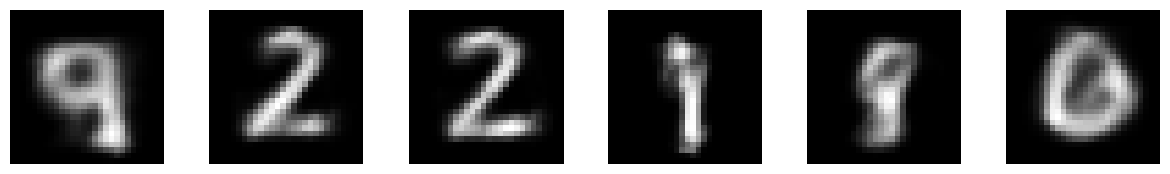


##################################################
VAE-MLP Epoch [8/20], Loss: 9717.279750799573
Sample Images:


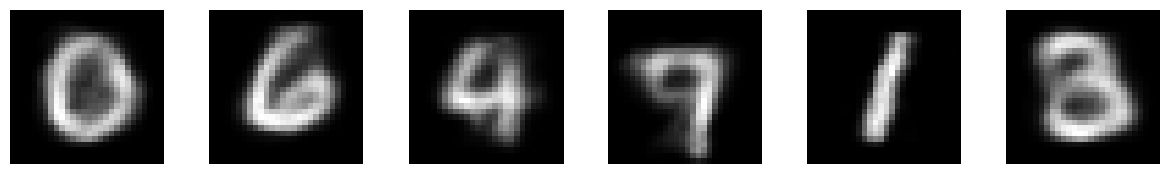


##################################################
VAE-MLP Epoch [9/20], Loss: 9656.506497055738
Sample Images:


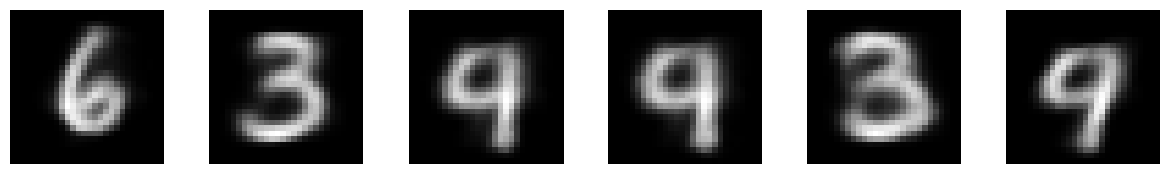


##################################################
VAE-MLP Epoch [10/20], Loss: 9616.145586936967
Sample Images:


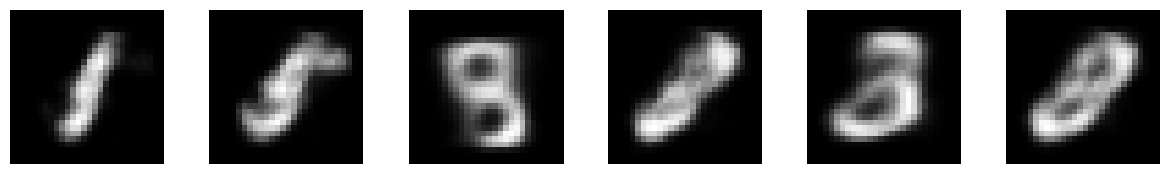


##################################################
VAE-MLP Epoch [11/20], Loss: 9586.995433164811
Sample Images:


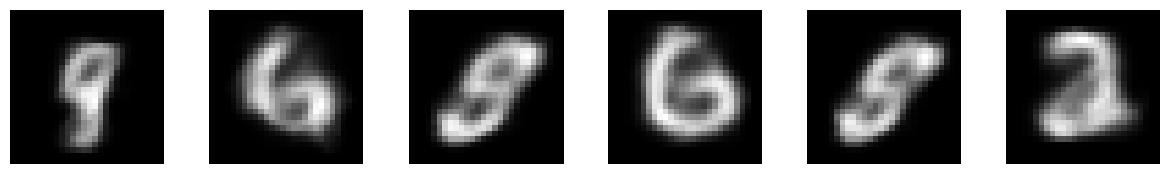


##################################################
VAE-MLP Epoch [12/20], Loss: 9549.952075559702
Sample Images:


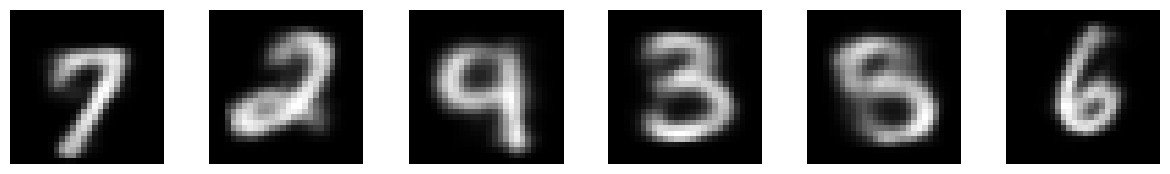


##################################################
VAE-MLP Epoch [13/20], Loss: 9517.097332984908
Sample Images:


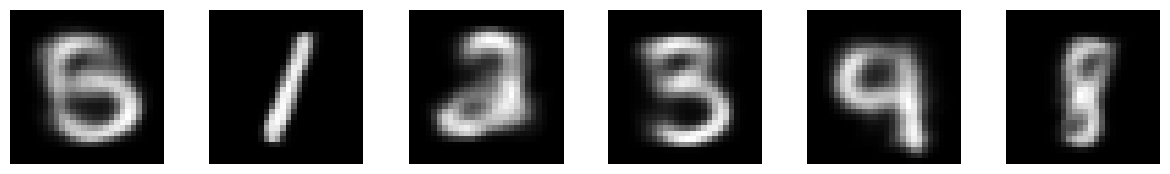


##################################################
VAE-MLP Epoch [14/20], Loss: 9492.267495877199
Sample Images:


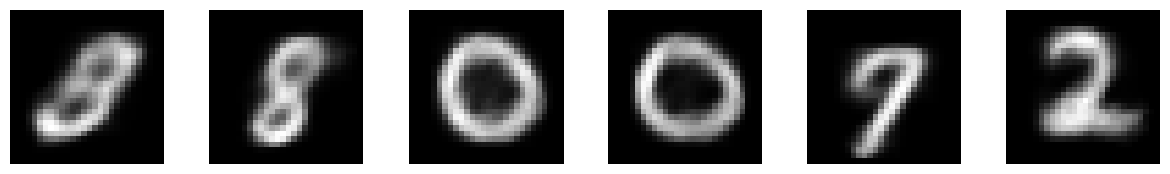


##################################################
VAE-MLP Epoch [15/20], Loss: 9468.076901173541
Sample Images:


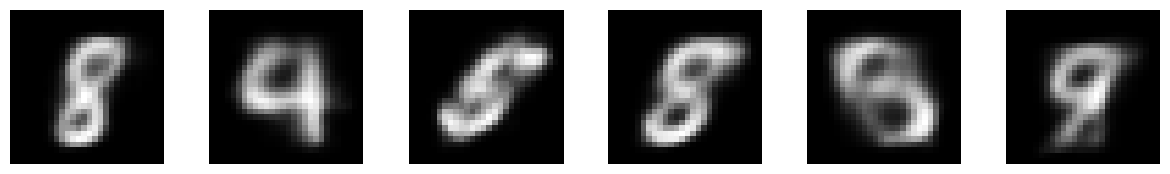


##################################################
VAE-MLP Epoch [16/20], Loss: 9452.653290640825
Sample Images:


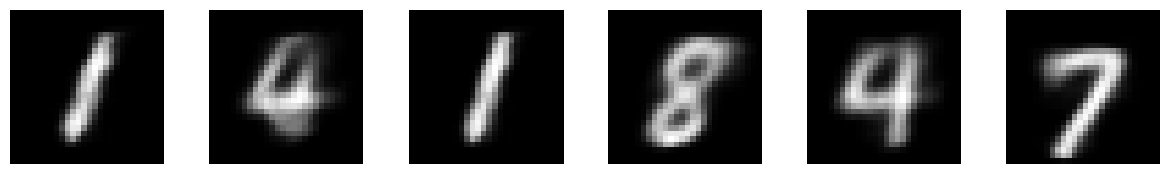


##################################################
VAE-MLP Epoch [17/20], Loss: 9427.758092038413
Sample Images:


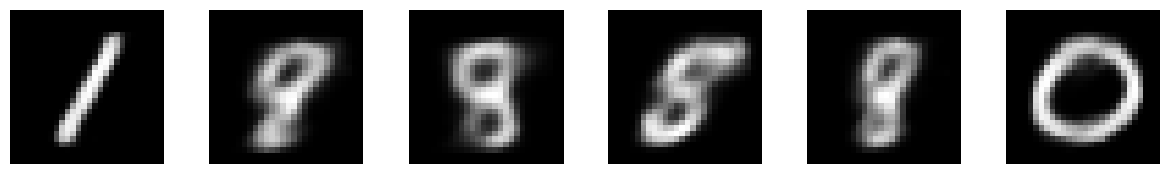


##################################################
VAE-MLP Epoch [18/20], Loss: 9397.911405583689
Sample Images:


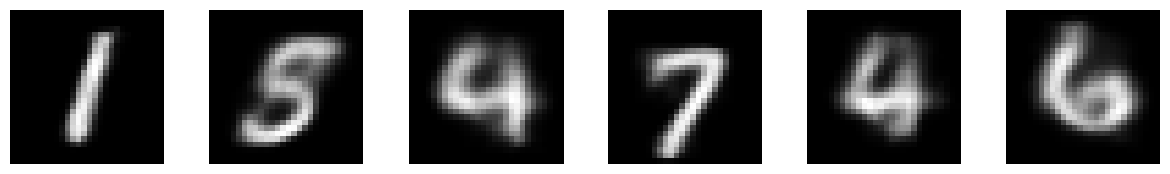


##################################################
VAE-MLP Epoch [19/20], Loss: 9380.887378814632
Sample Images:


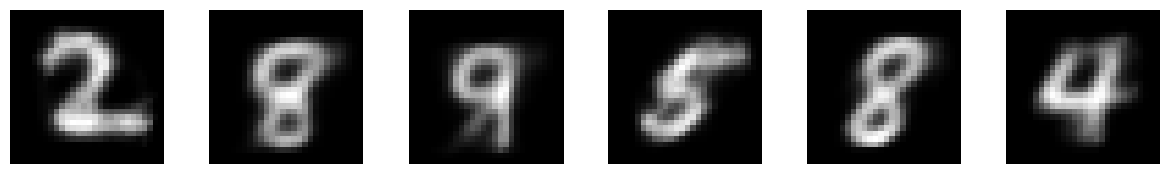


##################################################
VAE-MLP Epoch [20/20], Loss: 9381.453698652385
Sample Images:


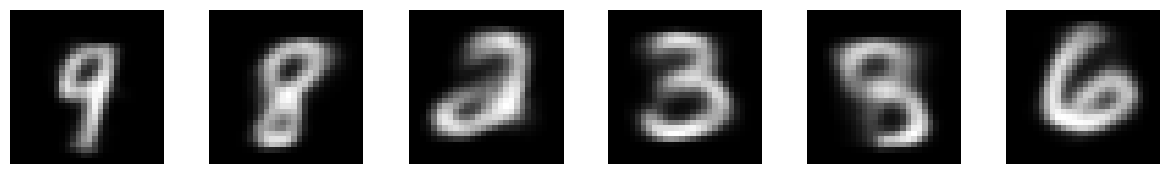

Best model saved as 'best_vae_mlp_model.pth'


In [ ]:
# Train VAE-MLP
vae_mlp = VAE_MLP(28*28, 400, 2)
train_vae_mlp(vae_mlp, train_loader, num_epochs= 20)

# 2) CVAE --> MLP

In [ ]:
# Define a simple CVAE class with MLP architecture

class CVAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes):
        super(CVAE_MLP, self).__init__()
        # TODO: Define the architecture of the encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc_class = nn.Linear(latent_dim, num_classes)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid())

    def reparameterize(self, mu, logvar):
        # TODO: Implement the reparameterization trick
        eps = torch.randn(mu.shape, device = mu.device)
        z = mu + torch.exp(logvar/2) * eps
        return z

    def forward(self, x, y):
        x = x.view(x.size(0), -1)
        y = y.view(y.size(0), -1)

        # TODO: Concatenate x and y before passing them to the encoder
        x = torch.cat((x,y), dim = 1)

        # TODO: Implement the forward pass
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        z = self.reparameterize(mu, logvar)
        class_logits = self.fc_class(z)

        reconstructed = self.decoder(torch.cat((z, y), dim= 1))

        return reconstructed, mu, logvar, class_logits


In [ ]:
# Define CVAE loss function
def cvae_loss(recon, data, mu, logvar, class_logits, labels):
    # TODO: Flatten the data tensor
    N = len(data)
    data = data.view(N , -1)

    # TODO: Implement the reconstruction loss
    reconstruction_loss = F.binary_cross_entropy(recon, data, reduction='none').mean(dim=1).mean()

    # TODO: Implement the KL divergence loss
    kl_divergence = 0.5 * (torch.exp(logvar) + mu**2 - 1 - logvar).sum(dim=1).mean()

    # TODO: Implement the cross-entropy loss for class prediction
    ce_loss = F.cross_entropy(class_logits, labels)

    # TODO: Return the total loss as the sum of reconstruction, KL divergence, and cross-entropy losses
    return 100*reconstruction_loss + kl_divergence + ce_loss


In [ ]:
# Training Loop - CVAE (MLP)
def train_cvae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    if(torch.cuda.is_available()):
      device = 'cuda'
    else:
      device = 'cpu'
    model.to(device)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            # One-hot encode the labels
            data = data.to(device)
            labels = labels.to(device)
            labels_one_hot = F.one_hot(labels, num_classes=10).to(dtype= torch.float, device = device)
            # TODO: Forward pass through the model and calculate the loss using cvae_loss
            recon, mu, logvar, class_logits = model(data, labels_one_hot)
            loss = cvae_loss(recon, data, mu, logvar, class_logits, labels)

            # TODO: Backpropagation and optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss = total_loss + loss.item()

        avg_loss = total_loss/ len(train_loader)
        print(f'CVAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_classes = 10  # Number of classes (0 to 9)
                num_samples_per_class = 1  # One sample per class
                # Generate random samples
                z = torch.randn(num_classes * num_samples_per_class, 2)
                # Generate one-hot encoded class labels
                y = torch.eye(num_classes).repeat(num_samples_per_class, 1)
                # Concatenate the random samples and class labels before passing them to the decoder
                sample = torch.cat([z, y], dim=1)
                sample = model.decoder(sample.to(device)).view(num_classes * num_samples_per_class, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_classes, figsize=(15, 2))
                for i in range(num_classes):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].set_title(f"Class {i}", fontsize=16)
                    axs[i].axis('off')
                plt.show()

        # TODO: Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()

    # TODO: Save the best model to a file
    torch.save(best_model, 'best_cvae_mlp_model.pth')
    print("Best model saved as 'best_cvae_mlp_model.pth'")



##################################################
CVAE-MLP Epoch [1/10], Loss: 25.230633812926726
Sample Images:


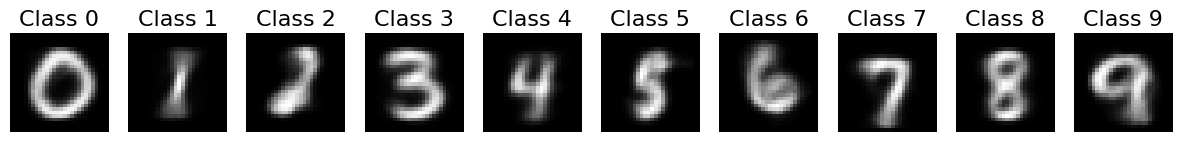


##################################################
CVAE-MLP Epoch [2/10], Loss: 22.65367943289946
Sample Images:


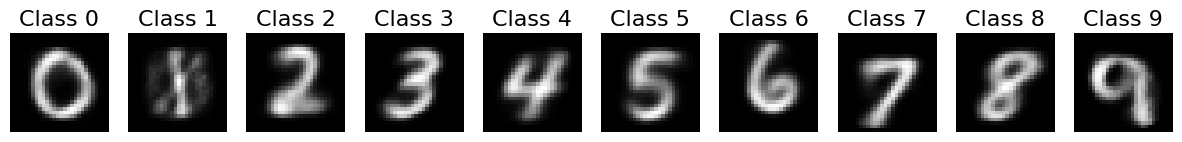


##################################################
CVAE-MLP Epoch [3/10], Loss: 22.377901860137484
Sample Images:


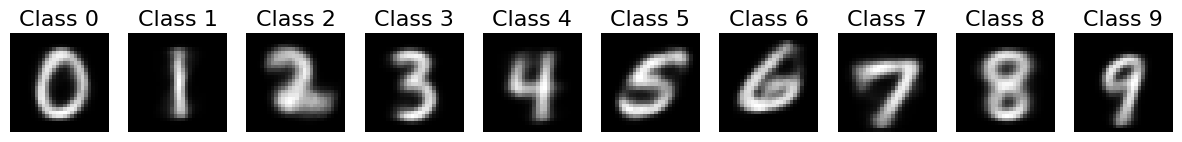


##################################################
CVAE-MLP Epoch [4/10], Loss: 22.22584842568013
Sample Images:


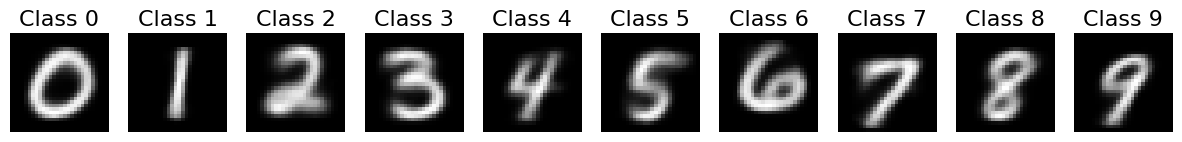


##################################################
CVAE-MLP Epoch [5/10], Loss: 22.143117388174225
Sample Images:


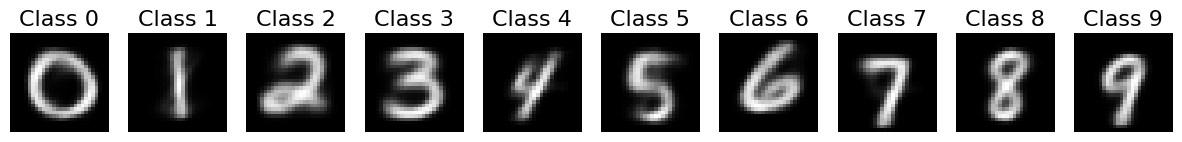


##################################################
CVAE-MLP Epoch [6/10], Loss: 22.0612706202688
Sample Images:


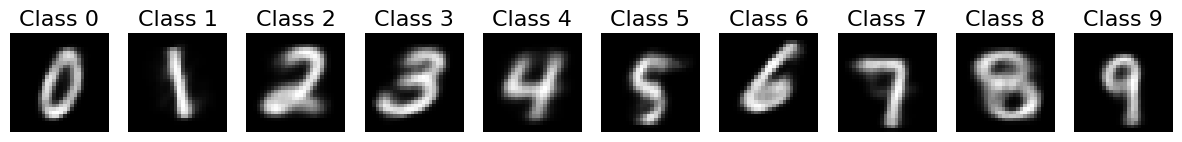


##################################################
CVAE-MLP Epoch [7/10], Loss: 22.017577899290302
Sample Images:


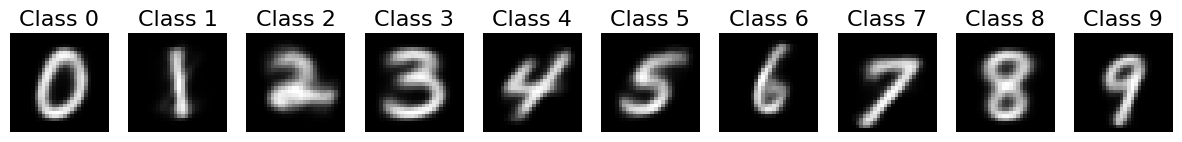


##################################################
CVAE-MLP Epoch [8/10], Loss: 21.96528624878255
Sample Images:


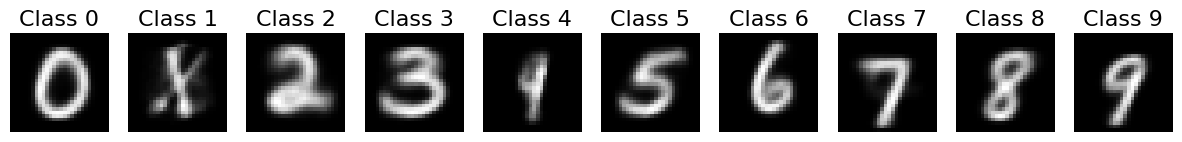


##################################################
CVAE-MLP Epoch [9/10], Loss: 21.93114188383383
Sample Images:


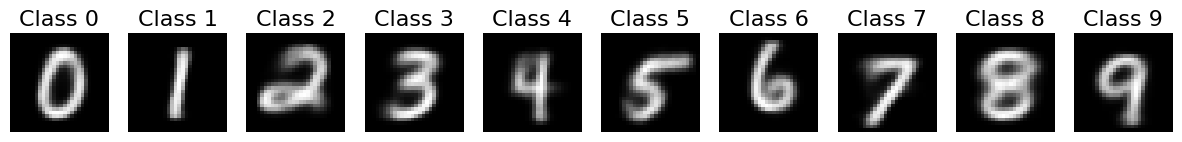


##################################################
CVAE-MLP Epoch [10/10], Loss: 21.898317831157367
Sample Images:


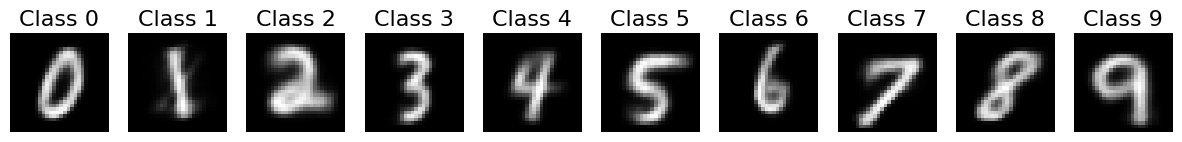

Best model saved as 'best_cvae_mlp_model.pth'


In [ ]:
cvae_mlp = CVAE_MLP(28*28, 300, 2, 10)
train_cvae_mlp(cvae_mlp, train_loader)

# 3) Visualizing Latent Space Distribution in Two Models

In this section, we will visualize the latent space distribution for two different models:

## Latent Space Distribution:

### VAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in VAE model.
2. Analyze the characteristics of the distribution.

### CVAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in CVAE model.
2. Analyze the characteristics of the distribution.


Summarize your findings and draw conclusions based on the observed differences in the latent space distribution between VAE (MLP) and CVAE (MLP).


In [ ]:
if(torch.cuda.is_available()):
  device = 'cuda'
else:
  device = 'cpu'

In [ ]:
def CVAE_latent_sample(model, x, y):
  x = x.view(x.size(0), -1)
  y = y.view(y.size(0), -1)
  x = torch.cat((x,y), dim = 1)
  hidden = model.encoder(x)
  mu = model.fc_mu(hidden)
  logvar = model.fc_logvar(hidden)
  z = model.reparameterize(mu, logvar)
  return z, y

def VAE_latent_sample(model, x, y):
  x = x.view(x.size(0), -1)
  out_encoder = model.encoder(x)
  mu = model.fc_mu(out_encoder)
  logvar = model.fc_logvar(out_encoder)
  latent_samples = model.reparameterize(mu, logvar)
  return latent_samples, y

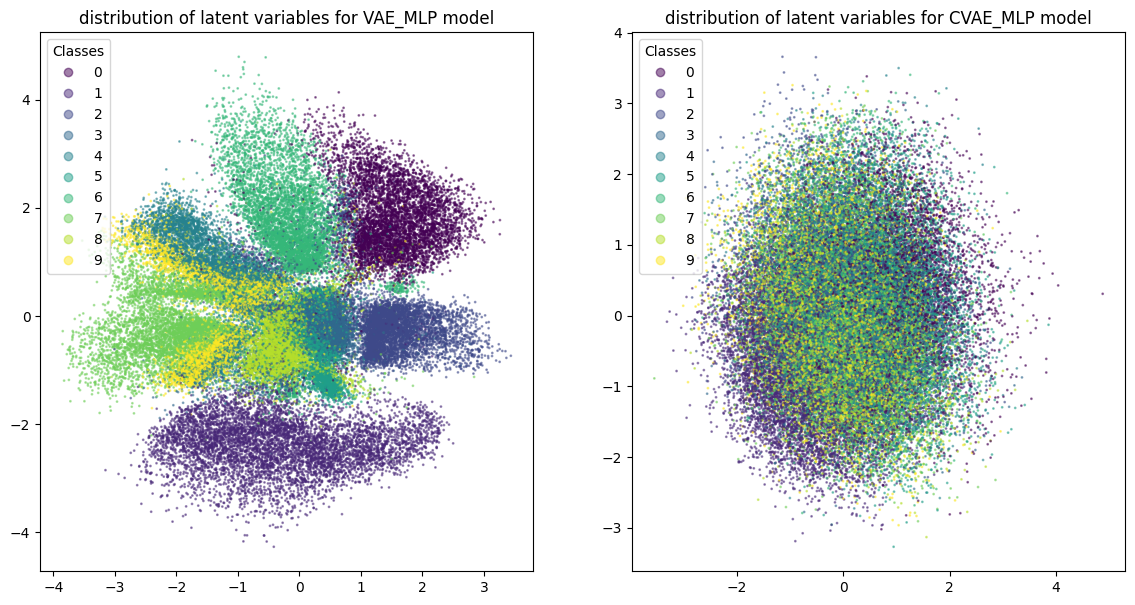

In [ ]:
cvae_mlp.to(device)
vae_mlp.to(device)
cvae_mlp.eval()
vae_mlp.eval()
fig, ax = plt.subplots(1,2, figsize = (14, 7))
ax[0].set_title('distribution of latent variables for VAE_MLP model')
ax[1].set_title('distribution of latent variables for CVAE_MLP model')
for x,y in train_loader:
  x = x.to(device)
  y = y.to(device)
  z, _ = VAE_latent_sample(vae_mlp, x, y)
  scatter1 = ax[0].scatter(z[:,0].cpu().detach(), z[:,1].cpu().detach(), c = y.to('cpu'), s = 1, alpha = 0.5)
  y_one_hot = F.one_hot(y, num_classes=10).to(dtype= torch.float)
  z, _ = CVAE_latent_sample(cvae_mlp, x, y_one_hot)
  scatter2 = ax[1].scatter(z[:,0].cpu().detach(), z[:,1].cpu().detach(), c = y.cpu(), s = 1, alpha = 0.5)
ax[0].legend(*scatter1.legend_elements(), title="Classes", loc="upper left")
ax[1].legend(*scatter2.legend_elements(), title="Classes", loc="upper left")

In the VAE model,  distribution of every class must be distinguishable because decoder has to create samples using only latent variables, but in CVAE models, decoder uses labels as input in additionally to latent variables so necessarily there is no need for latent vars to be separable based on input labels(classes), although we have added another classifier to our model and another loss to our total loss to make latent variables separable, but It's not enough to make them separable.